In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from scipy.optimize import minimize
import matplotlib.pyplot as plt

Использованные сслыки:
1. https://github.com/tthustla/efficient_frontier/blob/master/Efficient%20_Frontier_implementation.ipynb
2. https://www.kaggle.com/code/trangthvu/efficient-frontier-optimization
3. https://raniyer07.medium.com/modern-portfolio-theory-using-matrix-algebra-373444327a59



# Задание 1
Загрузка данных

In [3]:
df = pd.read_csv('project_RM.csv')
df['<DATE>'] = pd.to_datetime(df['<DATE>'], format="%d/%m/%y")
df.columns = ['TICKER', 'DATE', 'CLOSE']

In [4]:
tickers = df['TICKER'].unique()

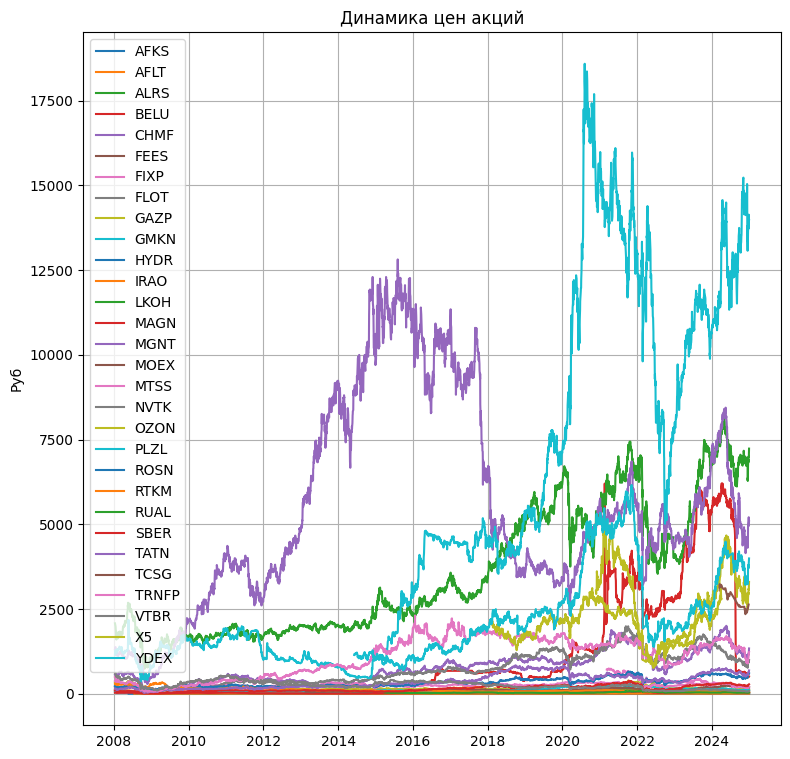

In [5]:
plt.figure(figsize = (9,9))
plt.title('Динамика цен акций')

for ticker in tickers:

    mask = df['TICKER'].eq(ticker)
    
    plt.plot(df[mask]['DATE'], df[mask]['CLOSE'], label = ticker)

plt.legend()
plt.grid()
plt.ylabel('Руб');

# Задание 2 - 3
Рассчитать для отобранных акций матрицы доходностей и ковариационные матрицы на различные даты

a. скользящим окном длиной в 1 год (опционально (*): 1 квартал, 1 месяц, 1 неделя, 1 день);  <br>
b. (*) расширяющимся окном с шагом в 1 год (опционально (*): 1 квартал, 1 месяц, 1 неделя, 1 день). <br>
3. (*) Выполнить п. 2 для схемы взвешивания наблюдений с экспоненциальным забыванием.

In [7]:
pivot_df = df.pivot(index='DATE', columns='TICKER', values='CLOSE').sort_index().asfreq('B').ffill()
# returns = pivot_df.pct_change()
returns = np.log(pivot_df / pivot_df.shift(1)) # Расчет логарифмических доходностей

# Параметры для скользящих и расширяющихся окон
window_params = {
    'rolling': {
        'year': {'size': 252, 'min_obs': 20},
        'quarter': {'size': 63, 'min_obs': 15},
        'month': {'size': 21, 'min_obs': 10},
        'week': {'size': 5, 'min_obs': 3},
        'day': {'size': 1, 'min_obs': 2}
    },
    'expanding': {
        'year': {'step': 252, 'min_obs': 20},
        'quarter': {'step': 63, 'min_obs': 15},
        'month': {'step': 21, 'min_obs': 10},
        'week': {'step': 5, 'min_obs': 3},
        'day': {'step': 1, 'min_obs': 2}
    }
}

lambda_ = 0.94
TICKERS = returns.columns.tolist()
results = {}

# Функция для экспоненциальных весов
# Исправленная функция весов
def exponential_weights(window_size, lambda_):
    weights = np.array([lambda_ ** i for i in range(window_size)][::-1])
    return weights / weights.sum()

# Улучшенная функция ковариации
def nan_aware_covariance(data, weights):
    weighted_sum = np.zeros((data.shape[1], data.shape[1]))
    sum_weights = np.zeros((data.shape[1], data.shape[1]))

    for i in range(data.shape[0]):
        row = data[i]
        valid = ~np.isnan(row)
        if not valid.any():
            continue

        centered = row - np.nanmean(row)
        centered[~valid] = 0
        w = weights[i]

        outer = np.outer(centered, centered)
        valid_matrix = np.outer(valid, valid)

        weighted_sum += w * outer * valid_matrix
        sum_weights += w * valid_matrix

    return np.divide(weighted_sum, sum_weights, where=sum_weights!=0)

# Обработка скользящих окон
for win_name, params in window_params['rolling'].items():
    win_size = params['size']
    min_obs = params['min_obs']

    rolling_results = {'simple': {}, 'exp': {}}
    valid_dates = 0

    for i in tqdm(range(win_size, len(returns)), desc=f'Rolling {win_name}'):
        current_date = returns.index[i]
        window_data = returns.iloc[i-win_size:i]

        if window_data.count().min() < min_obs:
            continue

        # Простая ковариация
        rolling_results['simple'][current_date] = window_data.cov()

        # С экспоненциальным забыванием
        weights = exponential_weights(win_size, lambda_)
        cov_exp = nan_aware_covariance(window_data.values, weights)
        rolling_results['exp'][current_date] = pd.DataFrame(cov_exp, index=TICKERS, columns=TICKERS)

        valid_dates += 1

    if valid_dates > 0:
        results[f'rolling_{win_name}_simple'] = pd.concat(rolling_results['simple'], names=['Date'])
        results[f'rolling_{win_name}_exp'] = pd.concat(rolling_results['exp'], names=['Date'])

# Обработка расширяющихся окон
for step_name, params in window_params['expanding'].items():
    step_size = params['step']
    min_obs = params['min_obs']

    expanding_results = {'simple': {}, 'exp': {}}
    valid_dates = 0
    prev_idx = -step_size

    for i in tqdm(range(len(returns)), desc=f'Expanding {step_name}'):
        if i - prev_idx >= step_size:
            current_date = returns.index[i]
            window_data = returns.iloc[:i+1]

            if len(window_data) < min_obs:
                prev_idx = i
                continue

            # Простая ковариация
            expanding_results['simple'][current_date] = window_data.cov()

            # С экспоненциальным забыванием
            current_win_size = len(window_data)
            weights = exponential_weights(current_win_size, lambda_)
            cov_exp = nan_aware_covariance(window_data.values, weights)
            expanding_results['exp'][current_date] = pd.DataFrame(cov_exp, index=TICKERS, columns=TICKERS)

            valid_dates += 1
            prev_idx = i

    if valid_dates > 0:
        results[f'expanding_{step_name}_simple'] = pd.concat(expanding_results['simple'], names=['Date'])
        results[f'expanding_{step_name}_exp'] = pd.concat(expanding_results['exp'], names=['Date'])

# Сохранение результатов (пример)
for key in results:
    print(f"{key}: {results[key].shape}")

Expanding day: 100%|██████████████████████████████████████████████████████████████| 4429/4429 [03:44<00:00, 19.70it/s]


rolling_year_simple: (5550, 30)
rolling_year_exp: (5550, 30)
rolling_quarter_simple: (5700, 30)
rolling_quarter_exp: (5700, 30)
rolling_month_simple: (5850, 30)
rolling_month_exp: (5850, 30)
rolling_week_simple: (6060, 30)
rolling_week_exp: (6060, 30)
expanding_year_simple: (510, 30)
expanding_year_exp: (510, 30)
expanding_quarter_simple: (2100, 30)
expanding_quarter_exp: (2100, 30)
expanding_month_simple: (6300, 30)
expanding_month_exp: (6300, 30)
expanding_week_simple: (26550, 30)
expanding_week_exp: (26550, 30)
expanding_day_simple: (132840, 30)
expanding_day_exp: (132840, 30)


In [8]:
print('Рассчитанные ковариационные матрицы:')
for k in results.keys():
    print(k)

Рассчитанные ковариационные матрицы:
rolling_year_simple
rolling_year_exp
rolling_quarter_simple
rolling_quarter_exp
rolling_month_simple
rolling_month_exp
rolling_week_simple
rolling_week_exp
expanding_year_simple
expanding_year_exp
expanding_quarter_simple
expanding_quarter_exp
expanding_month_simple
expanding_month_exp
expanding_week_simple
expanding_week_exp
expanding_day_simple
expanding_day_exp


# Задание 4
Выбрать одно историческое окно и схему взвешивания наблюдений для последующего расчёта границы эффективных портфелей для различных ограничений. Привести обоснование выбора.

In [9]:
# Выбор исторического окна: 2019-12-31 по 2024-12-31
start_date = '2019-12-31'
end_date = '2024-12-31'
df_window = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]

In [10]:
pivot_data = df_window.pivot(index='DATE', columns='TICKER', values='CLOSE').sort_index(ascending=True)

In [11]:
len(pivot_data)

1250

In [12]:
# Пропуски за период
pivot_data.isna().sum() / len(pivot_data) * 100

TICKER
AFKS      0.00
AFLT      0.00
ALRS      0.00
BELU      0.48
CHMF      0.00
FEES      1.12
FIXP     23.92
FLOT     15.44
GAZP      0.00
GMKN      0.32
HYDR      0.00
IRAO      0.00
LKOH      0.00
MAGN      0.00
MGNT      0.00
MOEX      0.00
MTSS      0.00
NVTK      0.00
OZON     18.16
PLZL      0.00
ROSN      0.00
RTKM      0.00
RUAL      0.32
SBER      0.00
TATN      0.00
TCSG     97.52
TRNFP     0.32
VTBR      0.32
X5       15.60
YDEX      2.40
dtype: float64

In [13]:
# Расчитаем доходности
returns = pivot_data.pct_change()

/tmp/ipykernel_205679/135244875.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = pivot_data.pct_change()


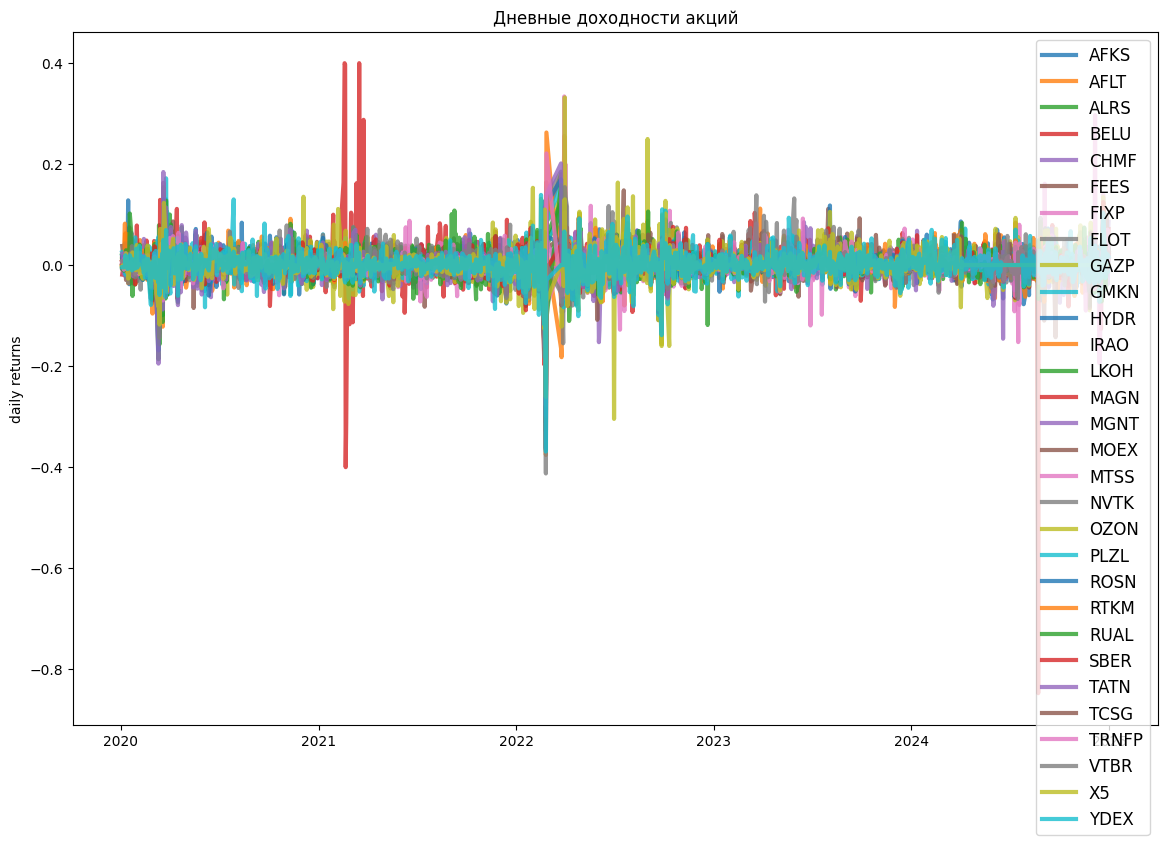

In [14]:
plt.figure(figsize=(14, 9))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')
plt.title('Дневные доходности акций');

Используя схему с экспоненциальным забыванием EWMA, рассчитаем веса:

In [15]:
# alpha = 0.97 - вес новых наблюдений
returns = returns.ewm(alpha = 0.97, adjust=False).mean() # y_t  = a*x_t + (1-a)*y_t-1 

In [16]:
returns

TICKER,AFKS,AFLT,ALRS,BELU,CHMF,FEES,FIXP,FLOT,GAZP,GMKN,...,ROSN,RTKM,RUAL,SBER,TATN,TCSG,TRNFP,VTBR,X5,YDEX
DATE,,,,,,,,,,,,,,,,,,,,,
2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,-0.006695,-0.001546,0.011978,-0.018919,0.008746,0.037679,NaN,NaN,0.010140,0.018113,...,0.016011,0.006253,-0.006331,0.000981,0.022377,NaN,0.006789,0.007407,-1.873975e-03,-0.004449
2020-01-07,-0.006290,0.001643,-0.000664,0.003441,-0.016967,0.008119,NaN,NaN,-0.008871,0.007526,...,-0.002280,-0.003503,-0.011124,-0.004155,-0.000203,NaN,-0.008790,-0.002505,-5.292079e-03,-0.004830
2020-01-09,0.003359,-0.005948,0.002370,-0.015864,-0.002388,-0.008453,NaN,NaN,-0.003140,0.013200,...,-0.007733,0.005452,-0.003700,0.019932,0.014994,NaN,0.014592,0.008655,-4.736393e-03,0.001670
2020-01-10,-0.001120,0.015096,0.026520,0.007641,0.000975,0.020657,NaN,NaN,-0.006617,-0.000190,...,0.017365,0.061065,0.020637,-0.003744,0.023469,NaN,0.000980,0.011727,1.963505e-02,0.018675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-26,0.027843,0.021171,0.000039,0.015044,0.021882,0.015062,-0.014618,0.031864,0.051600,0.028085,...,0.015829,0.011951,0.016023,0.026937,0.005615,-2.169215e-20,0.065720,0.034558,2.833658e-289,0.022207
2024-12-27,-0.003825,0.003818,0.019050,-0.009096,0.011176,-0.016643,-0.016467,-0.021271,-0.007689,0.015752,...,-0.004276,0.013798,0.017284,-0.006796,0.002789,9.648154e-02,0.003265,-0.008976,8.500974e-291,-0.000613
2024-12-28,0.013037,0.010865,0.012966,-0.002201,0.010082,0.003719,-0.019040,0.024178,0.006649,0.012679,...,0.019804,0.011870,0.022883,0.005698,0.007617,2.894446e-03,0.021194,0.009336,2.550292e-292,0.016127


# Задания 5 - 8
5.
Построить на выбранном в п. 4 историческом окне границу эффективных портфелей при условии, что короткие продажи разрешены и не имеют ограничений.
6.
Построить на выбранном в п. 4 историческом окне границу эффективных портфелей при условии, что короткие продажи разрешены, но доходы от короткой продажи каждой акции не должны превышать 25% от собственных средств (капитала) инвестора.
7.
Построить на выбранном в п. 4 историческом окне границу эффективных портфелей при условии, что короткие продажи запрещены.
8.
Построить на выбранном в п. 4 историческом окне границу эффективных портфелей при условии, что в каждую из акций должно быть вложено не менее 2% капитала.

__Граница эффективности портфелей__ - combination of stocks that has the lowest risk for a given expected return

### Логика, заложенная в `frontier.py`:

Для расчета функции `portfolio_annualised_performance()` используем:

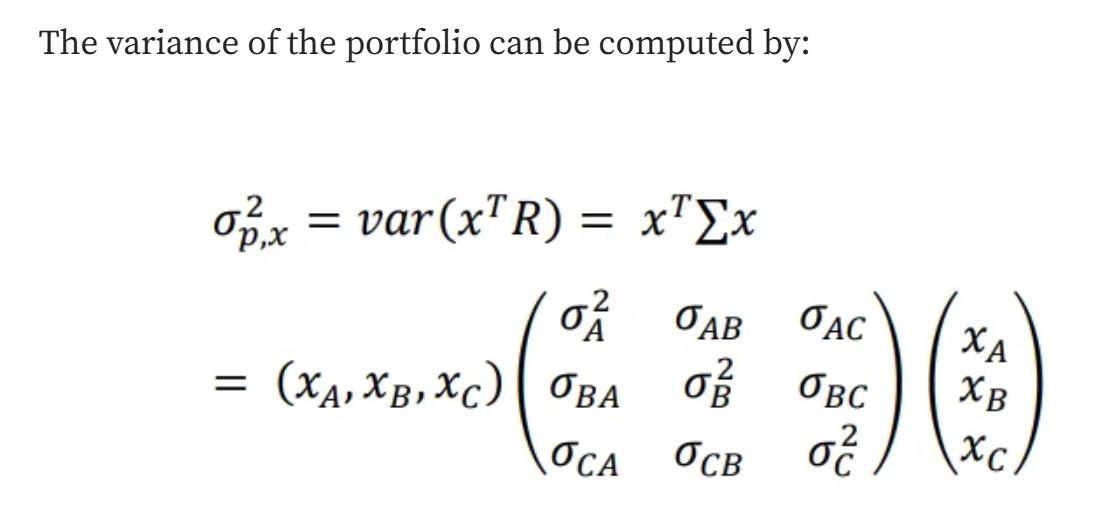

где $x_i$ -  доля инвестиций в актив i

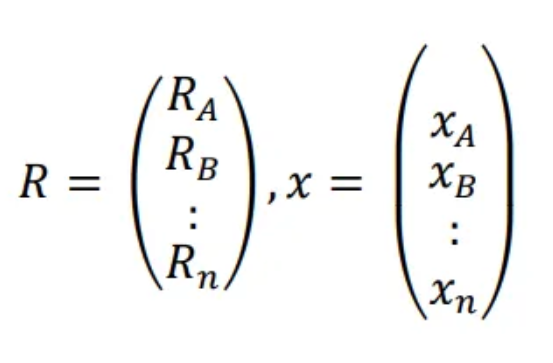

R - вектор доходностей по каждому активу <BR>
Доходность портфеля считается по формуле $return = x^TR$


Далее будем итерироваться по возможным доходностям r и подбирать такие веса для активов, чтобы минимизировать волатильность портфеля с такой доходностью.

In [17]:
mean_returns = returns.mean() # Средние доходности за период
cov_matrix = returns.cov() # Ковариационная матрица
risk_free_rate = 0.1 # Для расчета коэффициента Шарпа

In [18]:
from frontier import (portfolio_annualised_performance,
                        neg_sharpe_ratio,
                        max_sharpe_ratio,
                        portfolio_volatility,
                        min_variance,
                        calculated_results,
                        efficient_return
                    )

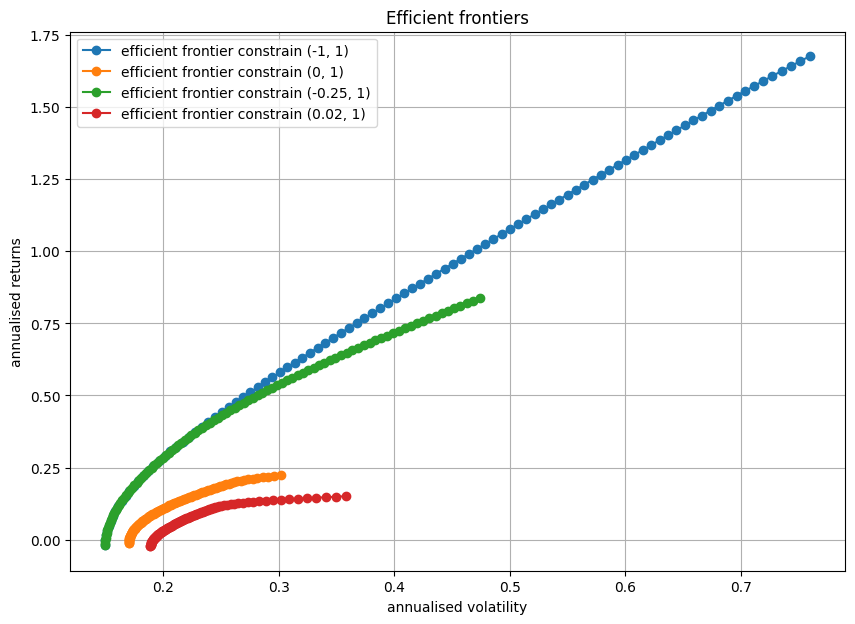

In [19]:
plt.figure(figsize=(10, 7))
plt.title(f'Efficient frontiers')

# короткие продажи разрешены без ограничений
constarin_set = (-1,1)
maxSR_std, maxSR_returns, minVol_std, minVol_returns, efficient_list, target_returns = calculated_results(mean_returns,
                                                                                                           cov_matrix,
                                                                                                           risk_free_rate,
                                                                                                           pivot_data,
                                                                                                          constarin_set)
plt.plot(efficient_list,target_returns, label = f'efficient frontier constrain {constarin_set}', marker = 'o')

# короткие продажи запрещены
constarin_set = (0,1)
maxSR_std, maxSR_returns, minVol_std, minVol_returns, efficient_list, target_returns = calculated_results(mean_returns,
                                                                                                           cov_matrix,
                                                                                                           risk_free_rate,
                                                                                                           pivot_data,
                                                                                                          constarin_set)
plt.plot(efficient_list,target_returns, label = f'efficient frontier constrain {constarin_set}', marker = 'o')

# доходы от короткой продажи каждой акции не должны превышать 25% от собственных средств (капитала) инвестора
constarin_set = (-0.25,1)
maxSR_std, maxSR_returns, minVol_std, minVol_returns, efficient_list, target_returns = calculated_results(mean_returns,
                                                                                                           cov_matrix,
                                                                                                           risk_free_rate,
                                                                                                           pivot_data,
                                                                                                          constarin_set)
plt.plot(efficient_list,target_returns, label = f'efficient frontier constrain {constarin_set}', marker = 'o')


# 0.02% капитала должно быть вложено в каждую акцию
constarin_set = (0.02,1)
maxSR_std, maxSR_returns, minVol_std, minVol_returns, efficient_list, target_returns = calculated_results(mean_returns,
                                                                                                           cov_matrix,
                                                                                                           risk_free_rate,
                                                                                                           pivot_data,
                                                                                                          constarin_set)
plt.plot(efficient_list,target_returns, label = f'efficient frontier constrain {constarin_set}', marker = 'o')


plt.xlabel('annualised volatility')
plt.ylabel('annualised returns')
plt.legend()
plt.grid()

# Задания 9 - 10

Продемонстрировать динамику изменения границы эффективных портфелей (без
ограничений – см. п. 5):
a. скользящим окном с шагом в 1 год (опционально (*): 1 квартал, 1 месяц, 1 неделя,
1 день);
b. (*) расширяющимся окном с шагом в 1 год (опционально (*): 1 квартал, 1 месяц, 1
неделя, 1 день).
10. (*) Выполнить п. 9 для схемы взвешивания наблюдений с экспоненциальным забыванием
(см. п. 3).


Статистика перед оптимизацией:
Минимальная доходность: -0.005173
Максимальная доходность: 0.002103
След ковариационной матрицы: 0.0144


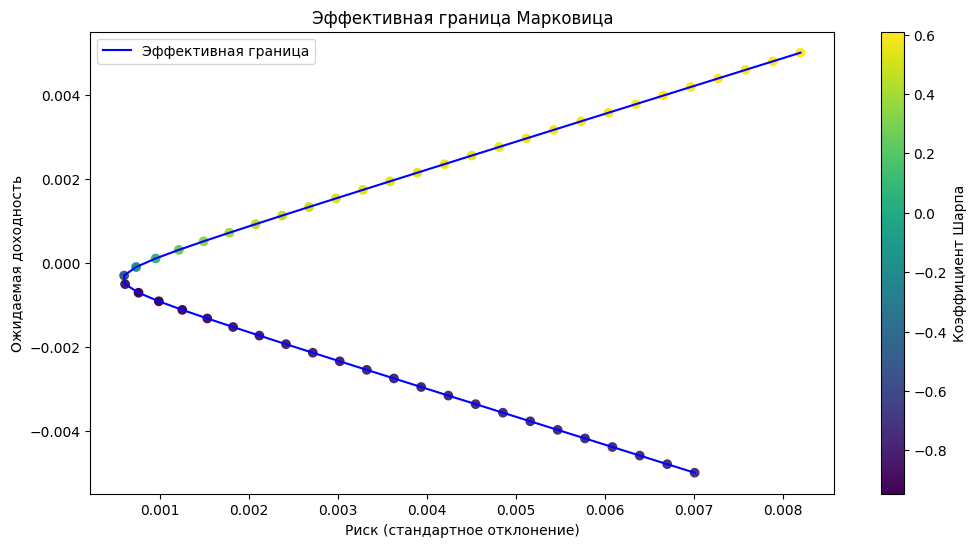


Оптимальный портфель:
Доходность: 0.50%
Риск: 0.82%
Коэффициент Шарпа: 0.61

Веса активов:
AFKS: 2.23%
AFLT: 41.11%
ALRS: -20.42%
BELU: -0.17%
CHMF: 0.45%
FEES: -14.18%
FIXP: 10.56%
FLOT: -35.50%
GAZP: 38.34%
GMKN: -42.04%
HYDR: -18.66%
IRAO: 0.10%
LKOH: -11.68%
MAGN: -10.11%
MGNT: 9.00%
MOEX: 24.90%
MTSS: 39.46%
NVTK: -51.38%
OZON: 14.38%
PLZL: 11.82%
ROSN: 33.16%
RTKM: 15.75%
RUAL: 35.84%
SBER: -6.34%
TATN: 1.81%
TCSG: 5.16%
TRNFP: -4.68%
VTBR: -44.16%
X5: 11.27%
YDEX: 63.97%


In [22]:
def calculate_efficient_frontier(expected_returns, cov_matrix, risk_free_rate=0.0, num_points=50):
    """
    Рассчитывает эффективную границу методом Марковица.

    Параметры:
        expected_returns (pd.Series): Ожидаемые доходности активов
        cov_matrix (pd.DataFrame): Ковариационная матрица
        risk_free_rate (float): Безрисковая ставка
        num_points (int): Количество точек на границе

    Возвращает:
        dict: Результаты оптимизации (доходности, риски, веса)
    """
    n_assets = len(expected_returns)

    min_ret = max(expected_returns.min(), -0.005)
    max_ret = max(expected_returns.max(), 0.005)
    target_returns = np.linspace(min_ret, max_ret, num_points)

    results = {
        'returns': [],
        'risks': [],
        'weights': [],
        'sharpe': []
    }

    cov_matrix = self_regularize_covariance(cov_matrix.values)
    cov_matrix = pd.DataFrame(cov_matrix,
                            index=expected_returns.index,
                            columns=expected_returns.index)

    def portfolio_risk(weights):
        port_var = weights @ cov_matrix.values @ weights.T
        return np.sqrt(abs(port_var))

    def portfolio_return(weights):
        return weights @ expected_returns.values

    for target in target_returns:
        constraints = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'eq', 'fun': lambda w: portfolio_return(w) - target}
        ]
        bounds = [(-1, 1) for _ in range(n_assets)]

        init_weights = np.random.dirichlet(np.ones(n_assets))

        try:
            opt = minimize(
                fun=portfolio_risk,
                x0=init_weights,
                method='SLSQP',
                bounds=bounds,
                constraints=constraints,
                tol=1e-8,
                options={'maxiter': 1000}
            )

            if opt.success and not np.isnan(opt.fun) and opt.fun > 0:
                results['returns'].append(target)
                results['risks'].append(opt.fun)
                results['weights'].append(opt.x)
                sharpe = (target - risk_free_rate) / opt.fun
                results['sharpe'].append(sharpe)

        except Exception as e:
            continue

    return results

def self_regularize_covariance(matrix, max_attempts=5):
    """Автоматическая регуляризация ковариационной матрицы"""
    for i in range(max_attempts):
        try:
            np.linalg.cholesky(matrix)
            return matrix
        except np.linalg.LinAlgError:
            matrix += np.eye(matrix.shape[0]) * 1e-5 * (i+1)
    return matrix

last_date = results['rolling_year_exp'].index.get_level_values('Date')[-1]

cov_matrix = results['rolling_year_exp'].xs(last_date, level='Date').copy()

expected_returns = (
    returns
    .rolling(window=252, min_periods=10)
    .mean()
    .ffill()
    .bfill()
    .loc[last_date]
)

cov_matrix = cov_matrix.fillna(0).values
expected_returns = expected_returns.fillna(0).values

er_series = pd.Series(expected_returns,
                     index=returns.columns,
                     name='Returns')
cov_df = pd.DataFrame(cov_matrix,
                     columns=returns.columns,
                     index=returns.columns)

print("\nСтатистика перед оптимизацией:")
print(f"Минимальная доходность: {er_series.min():.6f}")
print(f"Максимальная доходность: {er_series.max():.6f}")
print(f"След ковариационной матрицы: {np.trace(cov_df.values):.4f}")

frontier = calculate_efficient_frontier(er_series, cov_df)

if not frontier['returns']:
    print("\nНе удалось построить эффективную границу!")
    print("Возможные причины:")
    print("- Невозможно достичь заданных целевых доходностей")
    print("- Проблемы с численной стабильностью")
    print("- Недостаточное количество активов")
else:
    plt.figure(figsize=(12, 6))
    plt.plot(frontier['risks'], frontier['returns'], 'b-', label='Эффективная граница')
    plt.scatter(frontier['risks'], frontier['returns'], c=frontier['sharpe'], cmap='viridis')
    plt.colorbar(label='Коэффициент Шарпа')
    plt.xlabel('Риск (стандартное отклонение)')
    plt.ylabel('Ожидаемая доходность')
    plt.title('Эффективная граница Марковица')
    plt.legend()
    plt.show()

    try:
        max_sharpe_idx = np.nanargmax(frontier['sharpe'])
        print("\nОптимальный портфель:")
        print(f"Доходность: {frontier['returns'][max_sharpe_idx]*100:.2f}%")
        print(f"Риск: {frontier['risks'][max_sharpe_idx]*100:.2f}%")
        print(f"Коэффициент Шарпа: {frontier['sharpe'][max_sharpe_idx]:.2f}")
        print("\nВеса активов:")
        for ticker, weight in zip(er_series.index, frontier['weights'][max_sharpe_idx]):
            print(f"{ticker}: {weight*100:.2f}%")
    except ValueError:
        print("\nНе удалось найти оптимальный портфель из-за отсутствия данных")

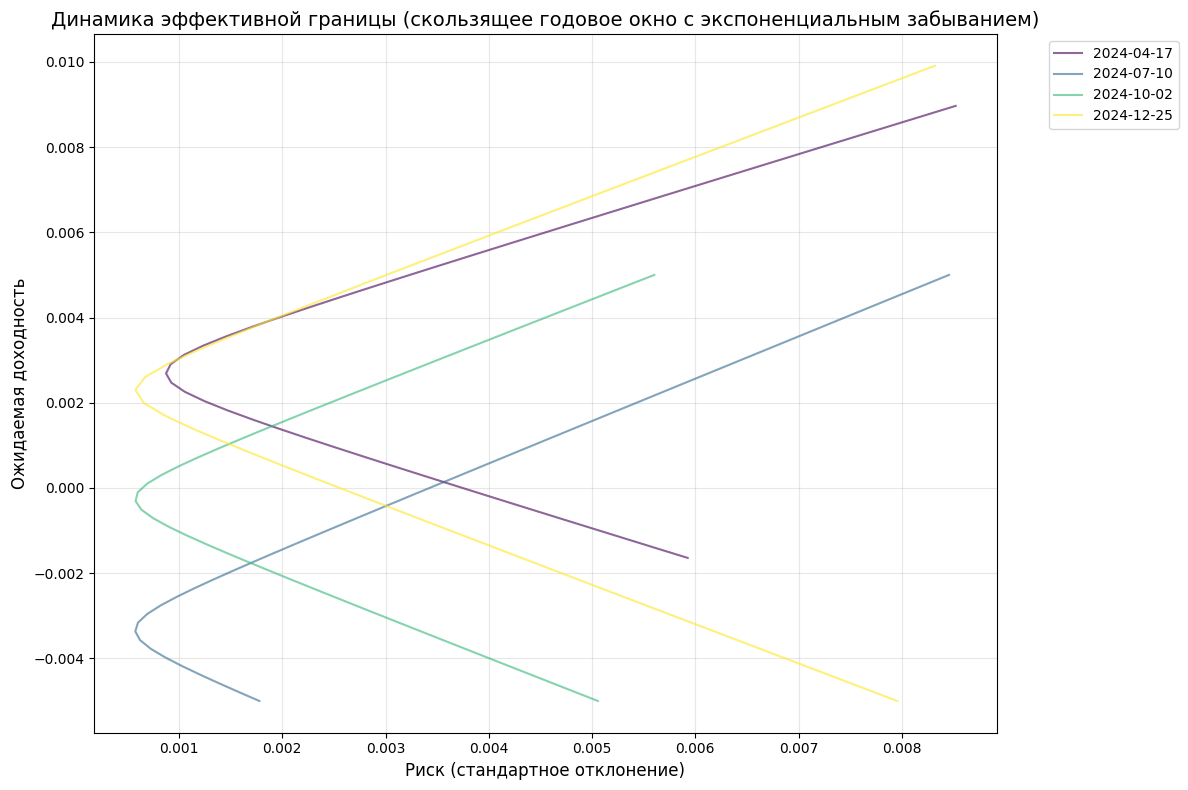

In [23]:
selected_dates = results['rolling_year_exp'].index.get_level_values('Date').unique()[::60]

plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(selected_dates)))

for i, date in enumerate(selected_dates):
    try:
        cov_matrix = results['rolling_year_exp'].xs(date, level='Date')

        idx = returns.index.get_loc(date)
        window_size = 252
        start_idx = max(0, idx - window_size + 1)
        window_data = returns.iloc[start_idx:idx+1]

        weights = exponential_weights(len(window_data), lambda_)
        weighted_returns = (window_data * weights[:, np.newaxis]).sum(axis=0)
        er_series = weighted_returns / weights.sum()

        cov_matrix = self_regularize_covariance(cov_matrix.values)
        cov_df = pd.DataFrame(cov_matrix,
                            index=er_series.index,
                            columns=er_series.index)

        frontier = calculate_efficient_frontier(er_series, cov_df)

        if not frontier['returns']:
            continue

        plt.plot(frontier['risks'], frontier['returns'],
                color=colors[i], alpha=0.6,
                label=f'{date.date()}')

    except Exception as e:
        print(f"Ошибка для даты {date}: {str(e)}")
        continue

plt.xlabel('Риск (стандартное отклонение)', fontsize=12)
plt.ylabel('Ожидаемая доходность', fontsize=12)
plt.title('Динамика эффективной границы (скользящее годовое окно с экспоненциальным забыванием)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()